# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
train_transform = transforms.Compose(
    [transforms.RandomVerticalFlip(), 
     transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

test_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(), 
     transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)


batchsize = 5
# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        transform=train_transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       transform=test_transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

deer


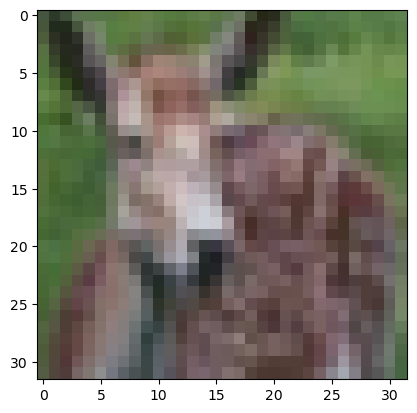

frog


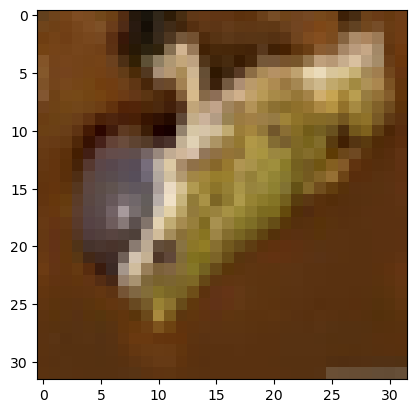

truck


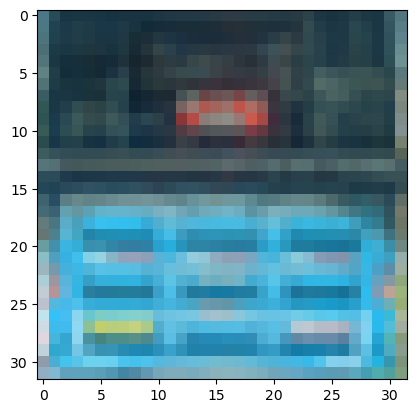

plane


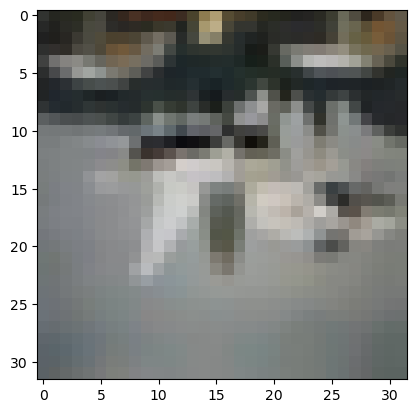

frog


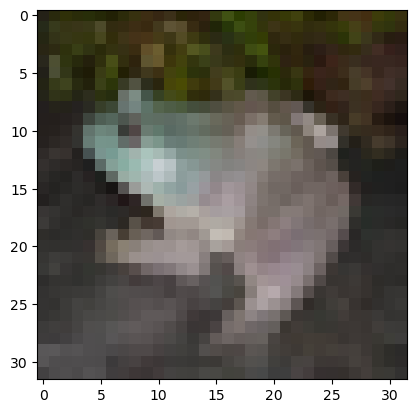

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        image = image/2+0.5       
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()
        
show5(trainloader)

In [5]:
#Explore Data
#Number of training images
NumTrain = 0

for data in trainloader:
    inputs, labels = data
    NumTrain += inputs.size(0)
 
print("Number of training images: " + str(NumTrain))

#Number of test images
NumTest = 0

for data in testloader:
    inputs, labels = data
    NumTest += inputs.size(0)
 
print("Number of test images: " + str(NumTest))

Number of training images: 50000
Number of test images: 10000


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [7]:
#Implementation of CNN and Pooling layers based on:
# https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
# https://www.knowledgehut.com/blog/data-science/padding-in-cnn
#https://www.baeldung.com/cs/deep-neural-networks-padding

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional layer
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=9, kernel_size=4),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=9, out_channels=24, kernel_size=5),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.ReLU(inplace=True)
        )

        # FC layer
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=384, out_features=160),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=160, out_features=80),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=80, out_features=10),
        )
            
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        
        return x


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
## YOUR CODE HERE ##
model = Classifier()
criterion = nn.CrossEntropyLoss()

# Use of Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.002)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
## YOUR CODE HERE ##
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)

model.to(device)

start = time.time()
epochs = 80 # Set how many epocs you want to run
steps = 0
running_loss = 0
train_losses = []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()    
        
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    train_losses.append(running_loss/len(trainloader))
    print(running_loss/len(trainloader))
    running_loss = 0
    model.train()

end = time.time()
    
print('Finished Training')

Running on cuda
1.7651830206394195
1.5684008398652076
1.4925587572991847
1.4431719546616077
1.4048049909979106
1.378245658057928
1.3636818284809589
1.3415501123473048
1.3321252628535032
1.318928938113898
1.3039414039447903
1.2979946887753904
1.282168449409306
1.272857537498884
1.2679783633247017
1.2707803217314184
1.2670656540483236
1.2602628641963005
1.2479789282221347
1.246967803195864
1.235824138377607
1.2311093787167222
1.2349959478673525
1.2339861125431955
1.2239728153653442
1.2210269109852612
1.2215682995896786
1.2255782615296542
1.223166633271426
1.2221888181816787
1.217230484572053
1.2104528954563663
1.2251873264856636
1.2148643941421062
1.2082993261698634
1.2014848810929806
1.2125121977508069
1.2133574298448861
1.197172479284741
1.2037346239294857
1.2019839666328394
1.1941127669919283
1.2066675196967087
1.1993310766877607
1.200225462038815
1.1924782832746395
1.1950722087147645
1.1887426202123053
1.1963076182287187
1.2000429989354684
1.1939766601623967
1.1995180927455424
1.1938

Plot the training loss (and validation loss/accuracy, if recorded).

In [10]:
trainingtime = end-start
print("Training the model took " + str(trainingtime//60) + " minutes and " + str(round(trainingtime%60,0)) + " seconds")

Training the model took 50.0 minutes and 54.0 seconds


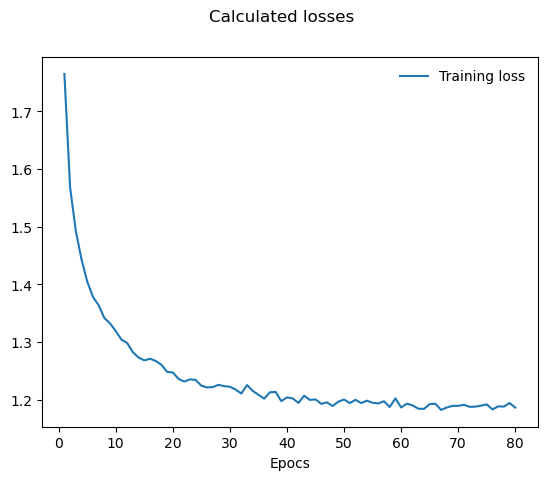

In [11]:
%matplotlib inline

plt.suptitle('Calculated losses')
plt.plot(range(1,len(train_losses)+1), train_losses, label='Training loss')
plt.xlabel('Epocs')
plt.legend(frameon=False)
plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
## YOUR CODE HERE ##
correctlyClass = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correctlyClass += (predicted == labels).sum()
    
    accuracy = (correctlyClass/total)*100

    #Total Accuracy
    print(f"Test Accuracy: {accuracy:.2f}")
    

Test Accuracy: 58.07


## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
## YOUR CODE HERE ##
torch.save(model.state_dict(), 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

I would recommend to develop an in-house solution. My model only achieves 58.07% accuracy compared vs the 70% achieved by Detectocorp's model and is also considerably below the accuracy achieved by more advanced solutions, but I'm sure that with more research, tuning and training it could surpass the 70% of accuracy. To get an accuracy of 58% I mainly did two things: fisrt, use convolutional neural networks combined with pooling layers to better identify the features of each image; and second, increase the number of epochs in which the model was trained, as I first attempted to train with 25 epochs and get an accuracy of 53%, but when I raised the number of epochs to 80 I got a 58% accuracy. To improve this accuracy I would slightly increase the number of epochs for training and look for other functions that I could add to the layers of my network. Simmilarly, I would adjust or change other parameter, like using another optimizer or update the learning rate in each iteration.